In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sys
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Set a consistent visual style
sns.set_theme(style="whitegrid")
warnings.simplefilter("ignore")

In [2]:
# Load dataset
df = pd.read_csv("Australian Vehicle Prices.csv")

In [3]:
display(df.head())

,Brand,Year,Model,Car/Suv,Title,UsedOrNew,Transmission,Engine,DriveType,FuelType,FuelConsumption,Kilometres,ColourExtInt,Location,CylindersinEngine,BodyType,Doors,Seats,Price
0,Ssangyong,2022.0,Rexton,Sutherland Isuzu Ute,2022 Ssangyong Rexton Ultimate (awd),DEMO,Automatic,"4 cyl, 2.2 L",AWD,Diesel,8.7 L / 100 km,5595,White / Black,"Caringbah, NSW",4 cyl,SUV,4 Doors,7 Seats,51990
1,MG,2022.0,MG3,Hatchback,2022 MG MG3 Auto Excite (with Navigation),USED,Automatic,"4 cyl, 1.5 L",Front,Premium,6.7 L / 100 km,16,Black / Black,"Brookvale, NSW",4 cyl,Hatchback,5 Doors,5 Seats,19990
2,BMW,2022.0,430I,Coupe,2022 BMW 430I M Sport,USED,Automatic,"4 cyl, 2 L",Rear,Premium,6.6 L / 100 km,8472,Grey / White,"Sylvania, NSW",4 cyl,Coupe,2 Doors,4 Seats,108988
3,Mercedes-Benz,2011.0,E500,Coupe,2011 Mercedes-Benz E500 Elegance,USED,Automatic,"8 cyl, 5.5 L",Rear,Premium,11 L / 100 km,136517,White / Brown,"Mount Druitt, NSW",8 cyl,Coupe,2 Doors,4 Seats,32990
4,Renault,2022.0,Arkana,SUV,2022 Renault Arkana Intens,USED,Automatic,"4 cyl, 1.3 L",Front,Unleaded,6 L / 100 km,1035,Grey / Black,"Castle Hill, NSW",4 cyl,SUV,4 Doors,5 Seats,34990


In [4]:
# Basic Exploration
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16734 entries, 0 to 16733
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Brand              16733 non-null  object 
 1   Year               16733 non-null  float64
 2   Model              16733 non-null  object 
 3   Car/Suv            16706 non-null  object 
 4   Title              16733 non-null  object 
 5   UsedOrNew          16733 non-null  object 
 6   Transmission       16733 non-null  object 
 7   Engine             16733 non-null  object 
 8   DriveType          16733 non-null  object 
 9   FuelType           16733 non-null  object 
 10  FuelConsumption    16733 non-null  object 
 11  Kilometres         16733 non-null  object 
 12  ColourExtInt       16733 non-null  object 
 13  Location           16284 non-null  object 
 14  CylindersinEngine  16733 non-null  object 
 15  BodyType           16452 non-null  object 
 16  Doors              151

In [5]:
print(df.describe())


               Year
count  16733.000000
mean    2016.229248
std        5.247705
min     1940.000000
25%     2013.000000
50%     2017.000000
75%     2020.000000
max     2023.000000


In [6]:
# Drop irrelevant columns
df = df.drop(['Title', 'ColourExtInt', 'Model', 'Car/Suv'], axis=1)

# Clean and parse columns
df['FuelConsumption'] = df['FuelConsumption'].str.split('/').str[0].str.split().str[0]
df['Location'] = df['Location'].str.split(',').str[1].str.strip()
df['Engine'] = df['Engine'].str.split(',').str[1].str.split().str[0]
df['CylindersinEngine'] = df['CylindersinEngine'].str.split().str[0]
df['Doors'] = df['Doors'].str.split().str[0]
df['Seats'] = df['Seats'].str.split().str[0]

# Replace invalid placeholders with NaN
df.replace(['-', 'POA'], np.nan, inplace=True)

# Drop rows with nulls in critical columns
df.dropna(subset=['Location', 'BodyType', 'Price', 'Transmission', 'FuelType', 'Kilometres'], inplace=True)

# Fill missing values in numerical columns with mode
for col in ['Engine', 'FuelConsumption', 'CylindersinEngine', 'Doors', 'Seats']:
    mode_val = df[~df[col].isnull()][col].astype(float if col in ['Engine','FuelConsumption'] else int).mode()[0]
    df[col].fillna(mode_val, inplace=True)

# Convert data types
df['Engine'] = df['Engine'].astype(float)
df['FuelConsumption'] = df['FuelConsumption'].astype(float)
df['Kilometres'] = df['Kilometres'].astype(float)
df['CylindersinEngine'] = df['CylindersinEngine'].astype(int)
df['Doors'] = df['Doors'].astype(int)
df['Seats'] = df['Seats'].astype(int)
df['Price'] = df['Price'].astype(float)

# Final check
df.info()
display(df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 15306 entries, 0 to 16733
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Brand              15306 non-null  object 
 1   Year               15306 non-null  float64
 2   UsedOrNew          15306 non-null  object 
 3   Transmission       15306 non-null  object 
 4   Engine             15306 non-null  float64
 5   DriveType          15306 non-null  object 
 6   FuelType           15306 non-null  object 
 7   FuelConsumption    15306 non-null  float64
 8   Kilometres         15306 non-null  float64
 9   Location           15306 non-null  object 
 10  CylindersinEngine  15306 non-null  int64  
 11  BodyType           15306 non-null  object 
 12  Doors              15306 non-null  int64  
 13  Seats              15306 non-null  int64  
 14  Price              15306 non-null  float64
dtypes: float64(5), int64(3), object(7)
memory usage: 1.9+ MB


,Brand,Year,UsedOrNew,Transmission,Engine,DriveType,FuelType,FuelConsumption,Kilometres,Location,CylindersinEngine,BodyType,Doors,Seats,Price
0,Ssangyong,2022.0,DEMO,Automatic,2.2,AWD,Diesel,8.7,5595.0,NSW,4,SUV,4,7,51990.0
1,MG,2022.0,USED,Automatic,1.5,Front,Premium,6.7,16.0,NSW,4,Hatchback,5,5,19990.0
2,BMW,2022.0,USED,Automatic,2.0,Rear,Premium,6.6,8472.0,NSW,4,Coupe,2,4,108988.0
3,Mercedes-Benz,2011.0,USED,Automatic,5.5,Rear,Premium,11.0,136517.0,NSW,8,Coupe,2,4,32990.0
4,Renault,2022.0,USED,Automatic,1.3,Front,Unleaded,6.0,1035.0,NSW,4,SUV,4,5,34990.0


,count,mean,std,min,25%,50%,75%,max
Engine,15306.0,2.386019,0.843115,0.7,2.00,2.0,2.80,7.3
FuelConsumption,15306.0,7.723429,2.139530,0.0,6.70,7.5,8.70,27.0
Kilometres,15306.0,101290.290017,78140.256535,1.0,42852.25,86690.5,147681.75,533849.0
Price,15306.0,35071.470273,31858.822964,88.0,18950.00,28950.0,41999.00,1500000.0


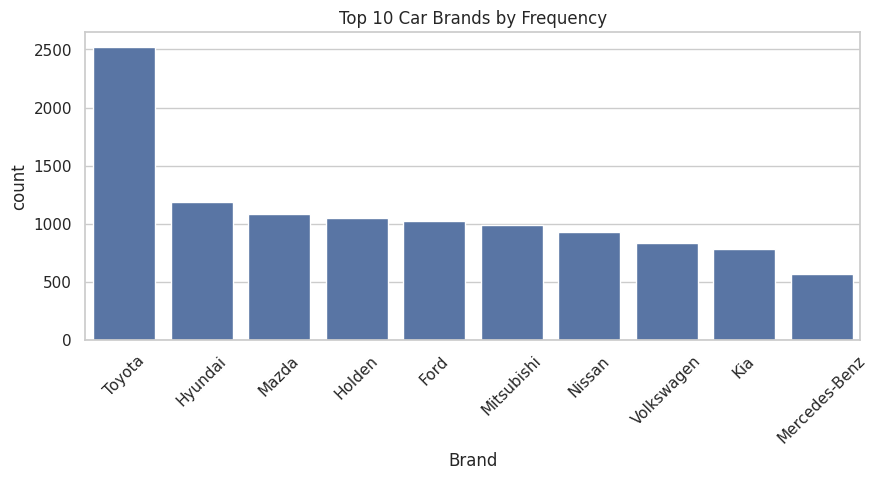

In [7]:
# Basic statistics on numeric fields
display(df[['Engine','FuelConsumption','Kilometres','Price']].describe().T)

# Distribution of brands (top 10 shown for clarity)
plt.figure(figsize=(10,4))
top_brands = df['Brand'].value_counts().head(10).index
sns.countplot(data=df[df['Brand'].isin(top_brands)], x='Brand', order=top_brands)
plt.title('Top 10 Car Brands by Frequency')
plt.xticks(rotation=45)
plt.show()

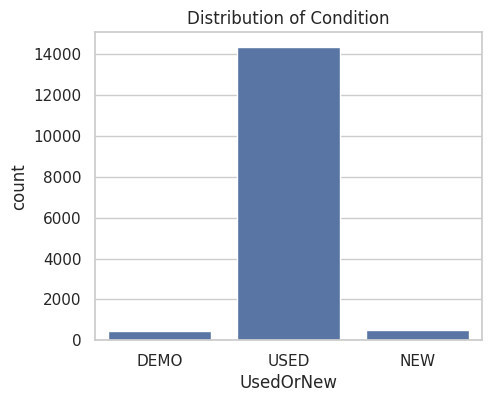

In [8]:
# Distribution of Used/New
plt.figure(figsize=(5,4))
sns.countplot(data=df, x='UsedOrNew')
plt.title('Distribution of Condition')
plt.show()


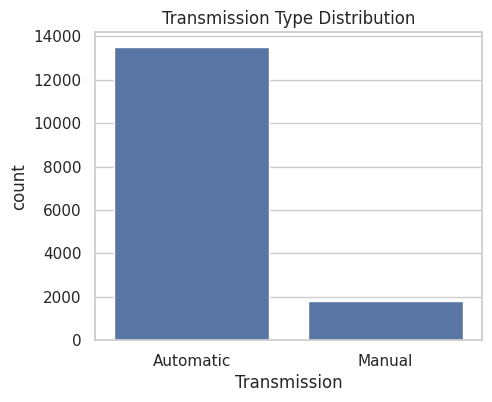

In [9]:
# Transmission distribution
plt.figure(figsize=(5,4))
sns.countplot(data=df, x='Transmission')
plt.title('Transmission Type Distribution')
plt.show()

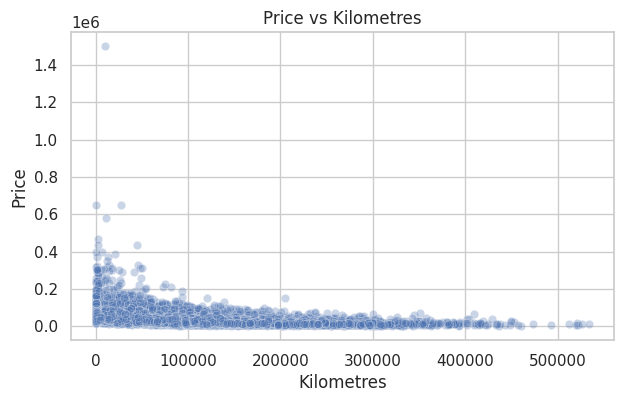

In [10]:
# Basic scatterplot Price vs Kilometres
plt.figure(figsize=(7,4))
sns.scatterplot(data=df, x='Kilometres', y='Price', alpha=0.3)
plt.title('Price vs Kilometres')
plt.show()

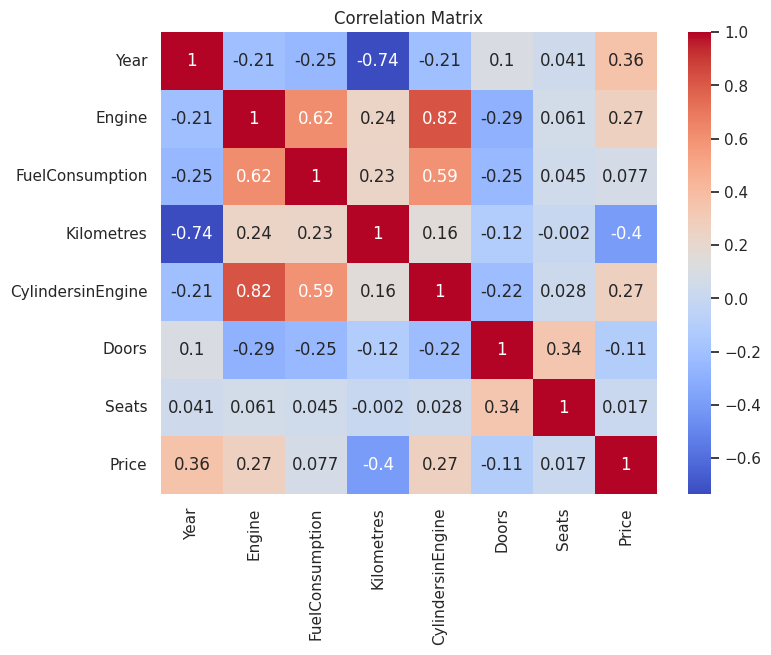

In [11]:
# Heatmap of numeric correlations
num_cols = df.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(8,6))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [12]:
# Subset data for assumption checks
y = df['Price']
X = df.drop(['Price'], axis=1)

# Encode categorical variables
LE = LabelEncoder()
df['Brand'] = LE.fit_transform(df['Brand'])

# One-hot encoding
cat_cols = ['UsedOrNew','Transmission','DriveType','FuelType','BodyType']
for col in cat_cols:
    dummies = pd.get_dummies(df[col], prefix=col).astype(int)
    df = pd.concat([df, dummies], axis=1)

df.drop(cat_cols + ['Location'], axis=1, inplace=True)

# Update X, y after encoding
y = df['Price']
X = df.drop('Price', axis=1)


In [13]:
# Check outliers with IQR and remove them
def remove_outliers(df, cols):
    for c in cols:
        Q1, Q3 = df[c].quantile([0.25,0.75])
        IQR = Q3 - Q1
        L = Q1 - 1.5*IQR
        U = Q3 + 1.5*IQR
        df = df[(df[c]>=L)&(df[c]<=U)]
    return df

outlier_cols = ['Year','Engine','FuelConsumption','Kilometres','Price']
df = remove_outliers(df, outlier_cols)

y = df['Price']
X = df.drop(['Price'], axis=1)

In [14]:
# Add constant for statsmodels
X_sm = sm.add_constant(X)
model = sm.OLS(y, X_sm).fit()

In [15]:
# Check for autocorrelation (Durbin-Watson)
dw_stat = durbin_watson(model.resid)
# Check heteroscedasticity (Breusch-Pagan)
bp_test = het_breuschpagan(model.resid, model.model.exog)
# Normality of residuals (Shapiro-Wilk)
shapiro_test = stats.shapiro(y)

print("\nRegression Diagnostic Tests:")
print(f"1. Durbin-Watson Statistic: {dw_stat:.8f} (Autocorrelation check)")
print(f"2. Breusch-Pagan Test: Chi-sq = {bp_test[0]:.8f}, p-value = {bp_test[1]:.8f} (Heteroscedasticity check)")
print(f"3. Shapiro-Wilk Test: W = {shapiro_test[0]:.8f}, p-value = {shapiro_test[1]:.8f} (Residuals normality check)")



Regression Diagnostic Tests:
1. Durbin-Watson Statistic: 1.96481031 (Autocorrelation check)
2. Breusch-Pagan Test: Chi-sq = 1210.58113512, p-value = 0.00000000 (Heteroscedasticity check)
3. Shapiro-Wilk Test: W = 0.95988373, p-value = 0.00000000 (Residuals normality check)


In [16]:
# The data shows non-normality and heteroscedasticity. Apply Box-Cox transform
Y_transformed, lambda_optimal = stats.boxcox(y)

# After transformation
X_sm_trans = sm.add_constant(X)
model_trans = sm.OLS(Y_transformed, X_sm_trans).fit()

In [17]:
vif_data = pd.DataFrame()
vif_data["FEATURE"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
display(vif_data)


,FEATURE,VIF
0,Brand,1.163408
1,Year,2.930385
2,Engine,4.505945
3,FuelConsumption,3.345125
4,Kilometres,2.729435
5,CylindersinEngine,2.365707
6,Doors,2.130247
7,Seats,1.993671
8,UsedOrNew_DEMO,inf
9,UsedOrNew_NEW,inf


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, Y_transformed, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_preds = lr_model.predict(X_test_scaled)

In [21]:
# Random Forest Regressor
rfg_params = {
    "n_estimators":[10,20,30],
    "max_features":["auto","sqrt","log2"],
    "min_samples_split":[2,4,8],
    "bootstrap":[True,False]
}
rfg_grid = GridSearchCV(RandomForestRegressor(), param_grid=rfg_params, cv=3)
rfg_grid.fit(X_train, y_train)
rfg_best = rfg_grid.best_estimator_
rfg_preds = rfg_best.predict(X_test)

In [22]:
def adj_r2(y_true, y_pred, X):
    r2 = r2_score(y_true, y_pred)
    return 1 - (1-r2)*(len(y_true)-1)/(len(y_true)-X.shape[1]-1)

def metrics(y_true, y_pred, X):
    return {
        "R-Squared": r2_score(y_true, y_pred),
        "Adjusted R-Squared": adj_r2(y_true, y_pred, X),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred),
        "MAPE": mean_absolute_percentage_error(y_true, y_pred)
    }

results = pd.DataFrame([
    metrics(y_test, lr_preds, X_test),
    metrics(y_test, rfg_preds, X_test)
], index=['Linear Regression','Random Forest'])

print("Model Performance Comparison:")
display(results)

Model Performance Comparison:


,R-Squared,Adjusted R-Squared,RMSE,MAE,MAPE
Linear Regression,0.794676,0.791820,10.715318,8.226371,0.073129
Random Forest,0.902945,0.901594,7.367070,5.283439,0.049381


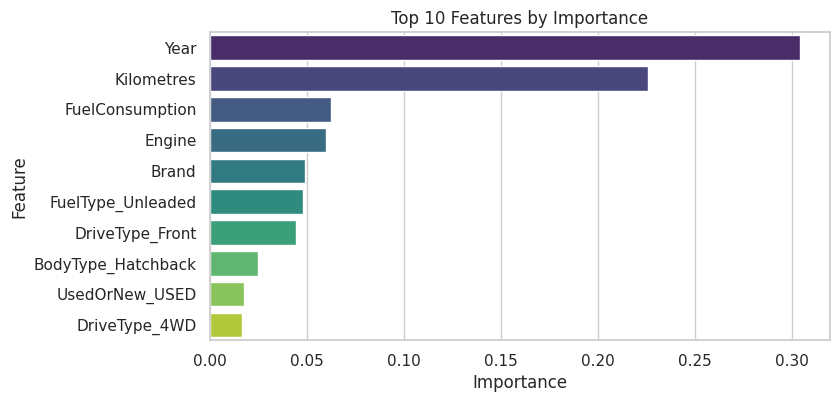

In [23]:
importances = rfg_best.feature_importances_
feat_importance = pd.DataFrame({'Feature':X.columns, 'Importance':importances})
feat_importance = feat_importance.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(8,4))
sns.barplot(x='Importance', y='Feature', data=feat_importance, palette='viridis')
plt.title('Top 10 Features by Importance')
plt.show()